In [1]:
import pandas as pd
from jellyfish import jaro_distance
import matplotlib.pyplot as plt
import itertools
from matplotlib import cm
from reference import s_protein_reference  # референсная последовательность s-протеина от 2019 года из Уханя

In [2]:
FILENAME_GENOME = 'sequences.fasta'

# скачанные геномы https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2, taxid:2697049&Completeness_s=complete

with open(FILENAME_GENOME, 'r') as f:
    genomes = f.read()
    
genomes[:200]

'>NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome\nATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCT\nGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGC'

In [3]:
genomes = genomes.split('>')
genomes = [i.split('\n') for i in genomes]
genomes = [{'Метаданные': i[0], 'Последовательность': ''.join(i[1:])} for i in genomes]
genomes = genomes[1:]

In [4]:
genomes[0]['Метаданные']

'NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome'

In [5]:
genomes[0]['Последовательность'][:50]

'ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTC'

In [6]:
def get_similarity_jaro(a, b):
    
    # Коэффициент близости последовательностей. Справочно.
    
    return jaro_distance(a, b)


def get_frames(string, length):
    
    # функция возвращает все возможные рамки считывания по геному
    
    frames = dict()
    for i in range(len(string) - length):
        frames[(i, i + length - 1)] = string[i:i + length]
        
    return frames


def get_coefficients(reference, target):
    
    # посчитать коэффициенты близости с референсной
    # последовательностью для каждой рамки
    # и определить правильную рамку считывания
    
    frames = get_frames(target, len(reference))
    similarity_data = list()
    for indexes, nucleotide_sequence in frames.items():
        if nucleotide_sequence[:3].upper() != 'ATG': # ген может начинаться только с ATG
            continue
            
        result = dict()
        coef_jaro = get_similarity_jaro(reference, nucleotide_sequence)
        
        result['Рамка_считывания'] = nucleotide_sequence
        result['Коэффициент_близости'] = coef_jaro
        
        similarity_data.append(result)
    
    return similarity_data


def get_max_similarity(similarity_data):
    return max([i['Коэффициент_близости'] for i in similarity_data])


def get_most_similar_frame(max_coef):
    
    # возвращает наиболее подходящую рамку считывания
    
    for dct in similarity_data:
        if dct['Коэффициент_близости'] == max_coef:
            return dct['Рамка_считывания']
        
        
def is_correct_AGTC(genome):
    
    # некоторые геномы включают неопределившиеся при секвенировании нуклеотиды (N)
    
    if set(genome) == set(['A', 'G', 'T', 'C']):
        return True
    return False


def get_mutations(reference, target):
    
    # возвращает мутации в виде (позиция, 'исходный нуклеотид -> новый')
    
    mutations = list()
    for n, (r, t) in enumerate(zip(reference, target)):
        if r != t:
            mutations.append((n, f'{r} -> {t}'), )
            
    return tuple(mutations)


def flatten(lst2d):
    
    # преобразовать массив из 2d в 1d
    
    return list(itertools.chain.from_iterable(lst2d))

In [7]:
df = pd.DataFrame(columns=['Метаданные', 'Коэффициент_близости', 's-protein'])

for genome in genomes:
    title = genome['Метаданные']
    sequence = genome['Последовательность']
    
    if len(sequence) < 28000:  # пропускаем неполные геномы
        continue
        
    sequence = sequence[21000:]  # обрезаем самое начало и самый конец
    sequence = sequence[:-4000]  # чтобы не перебирать рамку считывания по этому лишнему интервалу
    sequence = sequence.upper()
    
    if not is_correct_AGTC(sequence):
        continue
        
    similarity_data = get_coefficients(s_protein_reference, sequence)
    max_similarity = get_max_similarity(similarity_data)
    best_nucleotide_sequence = get_most_similar_frame(max_similarity)
    
    df_seq = pd.DataFrame([[title,
                            max_similarity,
                            best_nucleotide_sequence]],
                            columns=['Метаданные',
                                     'Коэффициент_близости',
                                     's-protein'])
        
    df = df.append(df_seq, ignore_index=True)
    
df = df[df['Коэффициент_близости'] > 0.9]  # отсекаем один ошибочный геном
df['Мутации'] = [get_mutations(s_protein_reference, i) for i in df['s-protein']]
df.head()

,Метаданные,Коэффициент_близости,s-protein,Мутации
0,NC_045512 |Severe acute respiratory syndrome c...,1.000000,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,()
1,MT186683 |Severe acute respiratory syndrome co...,1.000000,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,()
2,MT252677 |Severe acute respiratory syndrome co...,1.000000,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,()
3,MT252678 |Severe acute respiratory syndrome co...,0.999128,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,"((1840, A -> G),)"
4,MT252679 |Severe acute respiratory syndrome co...,1.000000,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,()


In [8]:
mutations = sorted(set(flatten(df['Мутации'])))
mutations

[(12, 'C -> T'),
 (25, 'C -> T'),
 (32, 'C -> T'),
 (79, 'C -> T'),
 (80, 'A -> C'),
 (81, 'T -> A'),
 (83, 'C -> T'),
 (85, 'C -> T'),
 (144, 'C -> T'),
 (148, 'C -> T'),
 (158, 'C -> T'),
 (161, 'G -> C'),
 (179, 'C -> T'),
 (211, 'C -> T'),
 (221, 'T -> A'),
 (237, 'G -> T'),
 (267, 'G -> T'),
 (287, 'G -> T'),
 (330, 'G -> A'),
 (347, 'C -> T'),
 (348, 'C -> T'),
 (442, 'A -> G'),
 (470, 'C -> A'),
 (488, 'G -> T'),
 (541, 'G -> T'),
 (557, 'C -> T'),
 (588, 'A -> G'),
 (644, 'T -> C'),
 (661, 'C -> G'),
 (662, 'G -> A'),
 (718, 'C -> T'),
 (740, 'T -> G'),
 (772, 'G -> T'),
 (811, 'A -> G'),
 (869, 'C -> T'),
 (881, 'C -> T'),
 (892, 'A -> G'),
 (905, 'G -> T'),
 (953, 'T -> C'),
 (967, 'C -> T'),
 (1041, 'G -> A'),
 (1043, 'A -> T'),
 (1098, 'G -> T'),
 (1421, 'G -> A'),
 (1425, 'G -> A'),
 (1447, 'T -> C'),
 (1556, 'T -> A'),
 (1557, 'G -> T'),
 (1584, 'A -> G'),
 (1622, 'C -> T'),
 (1667, 'C -> T'),
 (1679, 'G -> T'),
 (1708, 'C -> T'),
 (1721, 'T -> C'),
 (1840, 'A -> G'),
 (1

In [9]:
# подготовка данных в 2d-вид для диаграммы

x_length = 84
y_length = 46
empty_end = 42
mutations_positions = [i[0] for i in mutations]
s_protein_reference_map = s_protein_reference

mutations_map_values = [1 if i in mutations_positions else 0 for i in range(len(s_protein_reference))]
mutations_map = [mutations_map_values[i:i+x_length] for i in range(0, len(mutations_map_values), x_length)]
mutations_map_text = [s_protein_reference_map[i:i+x_length] for i in range(0, len(s_protein_reference_map), x_length)]
mutations_map[-1] += [0] * empty_end
mutations_map_text[-1] += ' ' * empty_end

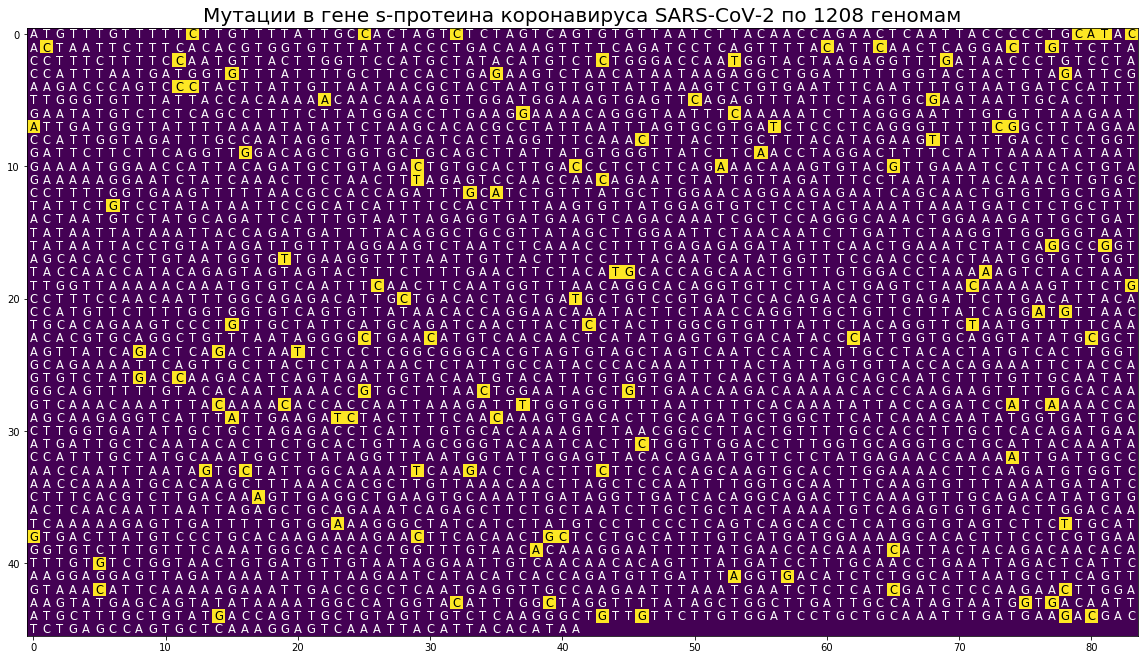

In [10]:
plt.figure(figsize=[16, 9])
plt.imshow(mutations_map)

for i in range(y_length):
    for j in range(x_length):
        color = 'w'
        if mutations_map[i][j] != 0:
            color = 'k'
            
        text = plt.text(j, i, mutations_map_text[i][j],
                        ha="center", va="center", color=color, size=11.5)

plt.tight_layout()
plt.title(f'Мутации в гене s-протеина коронавируса SARS-CoV-2 по {len(df)} геномам', size=20);